In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
words = open('../names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [57]:
vocab_size = len(words)
vocab_size

32033

In [59]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# build dataset

block_size = 3 # content length: how many characters do we use to predict the next one?
X, Y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix] # crop and append, chop first and add to end

X = torch.tensor(X)
Y = torch.tensor(Y)


In [6]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [7]:
X

tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        ...,
        [26, 26, 25],
        [26, 25, 26],
        [25, 26, 24]])

Above shows the 32, three letter combinations seen for the five names

In [8]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

There are similarly 32 letters that are the labels corresponding to the desired output 

In [9]:
C = torch.randn((27,2)) # each character gets a 2D embedding

In [10]:
C[5]

tensor([-0.1995, -0.2682])

In [11]:
F.one_hot(torch.tensor(5), num_classes=27).float() @ C

tensor([-0.1995, -0.2682])

In [12]:
C[torch.tensor([5,6,7])] #  we can also index with a tensor

tensor([[-0.1995, -0.2682],
        [ 0.1050, -1.4276],
        [-1.0662, -1.0703]])

In [13]:
C[X].shape # can embed the entire X matrix

torch.Size([228146, 3, 2])

In [14]:
X[13,2]

tensor(1)

In [15]:
C[X][13,2]

tensor([ 1.3557, -0.9268])

In [16]:
C[1]

tensor([ 1.3557, -0.9268])

In [17]:
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [18]:
W1 = torch.randn((6, 100)) # the 6 comes from having 3-D inputs whose embeddings are two dimensional, the 100 is number of hidden layer neurons 
b1 = torch.randn(100)

In [19]:
emb @ W1 + b1 # this won't work because our input from the embeddings are 32x3x2 so we need to concat to make it 32x6


RuntimeError: mat1 and mat2 shapes cannot be multiplied (684438x2 and 6x100)

In [20]:
torch.cat([emb[:,0,:], emb[:,1,:], emb[:,2,:]],1)

tensor([[-0.0388, -1.5594, -0.0388, -1.5594, -0.0388, -1.5594],
        [-0.0388, -1.5594, -0.0388, -1.5594, -0.1995, -0.2682],
        [-0.0388, -1.5594, -0.1995, -0.2682, -0.2984, -1.1314],
        ...,
        [-0.2328,  0.1857, -0.2328,  0.1857, -0.3383,  0.3281],
        [-0.2328,  0.1857, -0.3383,  0.3281, -0.2328,  0.1857],
        [-0.3383,  0.3281, -0.2328,  0.1857,  0.4862,  0.4371]])

In [21]:
torch.cat(torch.unbind(emb,1), 1)

tensor([[-0.0388, -1.5594, -0.0388, -1.5594, -0.0388, -1.5594],
        [-0.0388, -1.5594, -0.0388, -1.5594, -0.1995, -0.2682],
        [-0.0388, -1.5594, -0.1995, -0.2682, -0.2984, -1.1314],
        ...,
        [-0.2328,  0.1857, -0.2328,  0.1857, -0.3383,  0.3281],
        [-0.2328,  0.1857, -0.3383,  0.3281, -0.2328,  0.1857],
        [-0.3383,  0.3281, -0.2328,  0.1857,  0.4862,  0.4371]])

In [22]:
emb.view(32,6) == torch.cat(torch.unbind(emb,1), 1)

RuntimeError: shape '[32, 6]' is invalid for input of size 1368876

In [23]:
# much more efficient to use view
# this is our hidden layer
h = torch.tanh(emb.view(-1,6) @ W1 + b1) # using -1 pytorch will infer the value
h

tensor([[-0.4288, -0.6575, -0.9726,  ..., -0.9835, -0.8814,  0.5057],
        [-0.9393,  0.1409, -0.9963,  ..., -0.9544, -0.5629, -0.2951],
        [ 0.8022, -0.9912, -0.9152,  ..., -0.9993,  0.3650,  0.2128],
        ...,
        [ 0.6573, -0.1691, -0.6415,  ..., -0.9683,  0.9482,  0.0227],
        [ 0.8706, -0.1564, -0.5502,  ..., -0.9845,  0.9546,  0.2316],
        [ 0.8220,  0.9621, -0.7650,  ..., -0.8607,  0.9420,  0.9117]])

In [24]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [25]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [26]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims = True)

In [27]:
prob.shape

torch.Size([228146, 27])

In [28]:
Y

tensor([ 5, 13, 13,  ..., 26, 24,  0])

In [29]:
prob[torch.arange(32), Y] # looks up the probability of the next character being the correct character


IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

In [30]:
loss = -prob[torch.arange(32), Y].log().mean() # calculate NLL for loss
loss

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [228146]

# Clean up

In [50]:
neurons = 225
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator = g) # each character gets a 2D embedding
W1 = torch.randn((30, neurons), generator = g) # the 6 comes from having 3-D inputs whose embeddings are two dimensional, the 100 is number of hidden layer neurons 
b1 = torch.randn(neurons, generator = g)
W2 = torch.randn((neurons, 27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [51]:
sum(p.nelement() for p in parameters) #  total num of params

13347

In [52]:
emb = C[X]
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)
logits = h @ W2 + b2
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
loss = -prob[torch.arange(32), Y].log().mean() # calculate loss
loss

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1140730x6 and 30x225)

In [53]:
loss = F.cross_entropy(logits, Y) # this can replace multiple lines above and with more efficiency
loss

ValueError: Expected input batch_size (32) to match target batch_size (228146).

In practice always use the built in function

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
# generate learning rates to try
lre = torch.linspace(-3, 0,1000) # better to step through the exponents linearly vs the actual learning rate
lrs = 10**lre

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:


for i in range(200000):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(32,))
    # forward pass
    emb = C[Xtr[ix]] # 32,3,2 instead of 200k,3,2
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    #lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)
    
print(loss.item())   # gives loss for minibatch

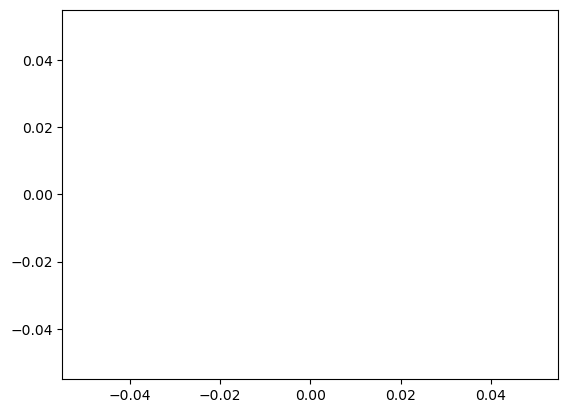

In [39]:
plt.plot(stepi, lossi)

In [79]:
emb = C[Xdev] # 32,3,2 instead of 200k,3,2
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
print(loss.item())

2.1727988719940186


In [49]:
emb = C[Xte] # 32,3,2 instead of 200k,3,2
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)
print(loss.item())

2.274513006210327


In [55]:
# build dataset
block_size = 3 # content length: how many characters do we use to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            #print(''.join(itos[i] for i in context), '---->', itos[ix])
            context = context[1:] + [ix] # crop and append, chop first and add to end
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(len(words) * .8)
n2 = int(len(words) * .9)

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


In [60]:
#MLP
n_embd = 10 # dim of char embedding vectors
n_hidden = 200 # num of neurons of hidden layer

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator = g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator = g)
b1 = torch.randn(n_hidden, generator = g)
W2 = torch.randn((n_hidden, vocab_size), generator = g)
b2 = torch.randn(vocab_size, generator = g)

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters)) 
for p in parameters:
    p.requires_grad = True
    

11897


In [61]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0,Xtr.shape[0],(batch_size,), generator = g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X, Y
    
    # forward pass
    emb = C[Xb] # embed characters into vectors using lookup C
    embcat = emb.view(emb.shape[0], -1) # concat vectors
    hpreact = embcat @ W1 + b1 # hidden layer preactivation
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # track stats
    #lri.append(lre[i])
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
print(loss.item())   # gives loss for minibatch

      0/ 200000: 25.5262
  10000/ 200000: 1.8167
  20000/ 200000: 2.2550
  30000/ 200000: 2.3921
  40000/ 200000: 2.6800
  50000/ 200000: 2.0062
  60000/ 200000: 2.6025
  70000/ 200000: 2.4147
  80000/ 200000: 1.9859
  90000/ 200000: 2.4731
 100000/ 200000: 2.3205
 110000/ 200000: 2.2909
 120000/ 200000: 2.0112
 130000/ 200000: 1.8076
 140000/ 200000: 2.3624
 150000/ 200000: 2.1782
 160000/ 200000: 2.0448
 170000/ 200000: 2.0956
 180000/ 200000: 2.7103
 190000/ 200000: 1.8285
2.1182198524475098


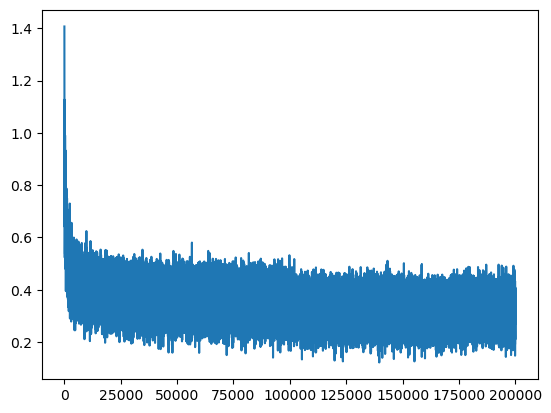

In [62]:
plt.plot(lossi)

In [63]:
@torch.no_grad()
def split_loss(split):
    x, y = {
     'train': (Xtr, Ytr),
     'val': (Xdev, Ydev),
     'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits,y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.122542142868042
val 2.182117462158203
